In [13]:
"""
- Artificial Neural Network with 1 hidden Layer
- Cost Function : SSE
- Activation Function : tanh

- Data : generated noisy sinc function


Author : Dr Kamel Saadi
Date   : 12/12/2017

incorporating bias for each node
most likely to enable bias only in the output node.

As we have seen in previous examples, if we don't use bias term
the sinc function nnet learning won't work
"""

import numpy as np
#---------------------- Classes --------------------------------------  

class layer:
    def __init__(self, activ, n_nodes, n_inputs,  biasFlag = True):
        self.n_nodes  = n_nodes
        self.n_inputs = n_inputs
        self.activ    = activ
        self.biasVal  = float(biasFlag) # this is to use later in the training
        self.acfunc, self.deriv_out = self.__generate_funcs() 
        self.w = 2*np.random.random([n_nodes, n_inputs+1])-1
        if not activ in ['linear','sigmoid','tanh']:
            print("Allowed activation function : linear,sigmoid,tanh")
        # self.biasVa if no use of bias it is set to 0
        # the last value in the weight represent the bias
        if not biasFlag: self.w[:,-1] = 0.0                                       
    
    def feed(self,x):
        d = np.dot(self.w, np.hstack((x,1.0)))
        return  self.acfunc(d)
    
    def feedData(self,X):        
        one = np.ones([X.shape[0],1])        
        d   = np.dot(np.hstack((X,one)),self.w.T)
        return self.acfunc(d) 
   
    def __generate_funcs(self):
        if self.activ=='linear':
            def tmp(x):return x   
            def tmp1p(y):return 1.0       
        elif self.activ=='sigmoid':
            def tmp(x): return 1.0/(1.0+np.exp(-x))
            def tmp1p(y): return y*(1-y)                        
        elif self.activ=='tanh':
            def tmp(x): return np.tanh(x)
            def tmp1p(y): return (1-y*y)            
        else: pass
        return tmp, tmp1p    
    
    def bias(self):
        return self.w[:,-1]  
    

class output_layer(layer):
    def __init__(self, cost, activ, n_nodes, n_inputs, biasFlag ):
        layer.__init__(self,activ, n_nodes, n_inputs, biasFlag)
        self.costType = cost
        if not cost in ['sse','entropy']:
            print("Allowed error cost functions : 'sse','entropy'") 
        #  costFunc is the error function (y-f)^2
        #  costFuncDeriv is derivative of the cost function w.r.t f 
        #  for example 2(y-f)(-1)
        #  y is the target and f is the predicted value
        self.costFunc, self.costFuncDeriv = self.__costFunction()            
            
    def __costFunction(self):
        if self.costType=='sse':
            def tmp(y,f):return (y-f)**2
            def tmp1p(y,f) : return 2*(f-y)
        elif self.costType=='entropy':
            def tmp(y,f): return -(y*np.log(f)+(1-y)*np.log(1-f)) 
            def tmp1p(y,f): return -(y/f - (1-y)/(1-f))      
        else: pass
        return tmp, tmp1p
 
    def score(self,x, prevLayer):
        # default is one hidden layer
        o1 = prevLayer.feedData(x)
        o2 = self.feedData(o1)
        return o2
    
    def score2(self,x, Layer2,Layer1 ):
        # NNET with 3 layers (2 hidden) current is L3
        o1 = L1.feedData(x)
        o2 = L2.feedData(o1)
        o3 = self.feedData(o2)
        return o3
        

In [14]:
np.random.seed(345)
XI = np.linspace(-10,10,500).reshape(-1,1)
n = XI.shape[0]
ytrue = np.sin(XI)/XI
YI = ytrue + 0.2*np.random.randn(n).reshape(n,1)  


import random 

n_tr = int(0.5*n)  # split 50/50

tr_ix = random.sample(range(n),n_tr)
te_ix = list(set(range(n))-set(tr_ix))

Xtr, Ytr = XI[tr_ix,:], YI[tr_ix,:]
Xte, Yte = XI[te_ix,:], YI[te_ix,:]


In [46]:
np.random.seed(3148)     
#np.random.seed(45)
n_nodes = 30             
in_dim = XI.shape[1]

#--------------------------------------------------------------------------

#np.random.seed(3148) good combo
#n_nodes = 30 
#L1    = layer('tanh',n_nodes ,in_dim, True) # no bias
#L2    = output_layer('sse','tanh',1, n_nodes, True) # bias 


n_nodes = 60
L1    = layer('tanh',n_nodes ,in_dim, True) # it is important that we have the bias here
# linear for L2 converge faster, tanh fits a bit better but take longer.
L2    = output_layer('sse','linear',1, n_nodes, True) #  

eta = 0.001

iters, sErr = 1000, np.Infinity
TrEnt       = []
TeEnt       = []
for i in range(iters):          
    #np.random.shuffle(X)
    for obs in range(Xtr.shape[0]):
        o0 , y = Xtr[obs,:], float(Ytr[obs])
        o1 = L1.feed(o0)
        o2 = float(L2.feed(o1))
       
        dCost_do2 = L2.costFuncDeriv(y,o2)
        
        delta2 = dCost_do2*L2.deriv_out(o2)   
        # here eta*delta applies to the last column of
        # the resulting hstack, i.e. the bias
        L2.w  += -eta*delta2*np.hstack((o1, L2.biasVal ))
            
        delta1 = delta2*L1.deriv_out(o1)            
        L1.w  += -eta*delta1.reshape(-1,1)*np.hstack((o0, L1.biasVal ))
        
    _tr = L2.costFunc(Ytr,L2.score(Xtr,L1))
    _te = L2.costFunc(Yte,L2.score(Xte,L1))
    
    train_err = float(sum(_tr))
    test_err  = float(sum(_te))
    sErr0     = sErr    
    sErr      = test_err  
    if (sErr-sErr0)/sErr0>1e-6 and i>50: 
       break    
    print("epoch = ",i," Validation =",round(sErr,4)," Training =", 
                                                   round(train_err,4) )
    TrEnt.append(train_err)    
    TeEnt.append(test_err)   


epoch =  0  Validation = 38.0646  Training = 38.472
epoch =  1  Validation = 19.6185  Training = 19.202
epoch =  2  Validation = 17.7028  Training = 16.889
epoch =  3  Validation = 16.7486  Training = 15.8571
epoch =  4  Validation = 16.2107  Training = 15.3881
epoch =  5  Validation = 16.0688  Training = 15.345
epoch =  6  Validation = 16.2572  Training = 15.6125
epoch =  7  Validation = 16.4673  Training = 15.8679
epoch =  8  Validation = 16.1802  Training = 15.5611
epoch =  9  Validation = 15.449  Training = 14.7156
epoch =  10  Validation = 15.117  Training = 14.2442
epoch =  11  Validation = 15.2832  Training = 14.3659
epoch =  12  Validation = 15.2909  Training = 14.4845
epoch =  13  Validation = 15.1982  Training = 14.5468
epoch =  14  Validation = 15.1423  Training = 14.6149
epoch =  15  Validation = 15.1278  Training = 14.6797
epoch =  16  Validation = 15.1195  Training = 14.7127
epoch =  17  Validation = 15.0856  Training = 14.6939
epoch =  18  Validation = 15.0122  Training 

epoch =  155  Validation = 12.5445  Training = 12.0442
epoch =  156  Validation = 12.5441  Training = 12.043
epoch =  157  Validation = 12.5437  Training = 12.0416
epoch =  158  Validation = 12.5432  Training = 12.0403
epoch =  159  Validation = 12.5428  Training = 12.0389
epoch =  160  Validation = 12.5423  Training = 12.0375
epoch =  161  Validation = 12.5418  Training = 12.0361
epoch =  162  Validation = 12.5413  Training = 12.0346
epoch =  163  Validation = 12.5408  Training = 12.0331
epoch =  164  Validation = 12.5402  Training = 12.0316
epoch =  165  Validation = 12.5396  Training = 12.0301
epoch =  166  Validation = 12.539  Training = 12.0285
epoch =  167  Validation = 12.5384  Training = 12.0269
epoch =  168  Validation = 12.5378  Training = 12.0253
epoch =  169  Validation = 12.5371  Training = 12.0236
epoch =  170  Validation = 12.5364  Training = 12.0219
epoch =  171  Validation = 12.5357  Training = 12.0202
epoch =  172  Validation = 12.535  Training = 12.0184
epoch =  173 

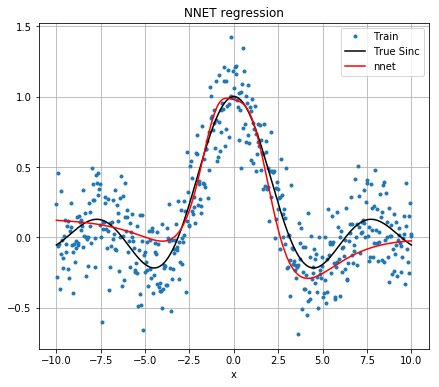

In [47]:
import  matplotlib.pyplot as plt

yhat = L2.score(XI,L1)

plt.figure(figsize=(7,6))
plt.plot(XI,YI,'.',label='Train')
plt.plot(XI,ytrue,'-k', label='True Sinc')
plt.plot(XI,yhat,'-r', label='nnet')
plt.xlabel('x')
plt.legend(loc='upper right')  
plt.title('NNET regression')
plt.grid()
plt.show()


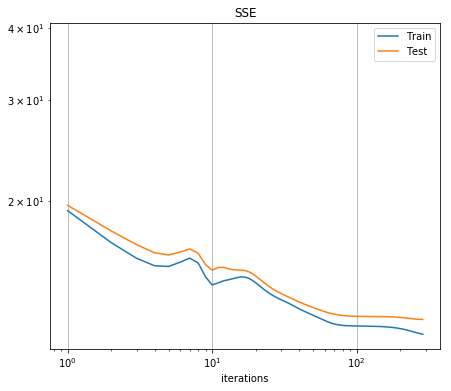

In [49]:
    
plt.figure(figsize=(7,6))
plt.loglog(TrEnt,label='Train')
plt.loglog(TeEnt, label='Test')
plt.xlabel('iterations')
plt.legend(loc='upper right') 
plt.title("SSE")
plt.grid()
plt.show()  

In [65]:
L2.bias()

array([-0.03722921])